# Model Selection
## Warning: time expensive algorithms

In [1]:
''' PACKAGES'''
import pandas as pd             

import numpy as np

import seaborn as sns
sns.set(style="dark", color_codes=True)
sns.set_context(rc={"font.family":'sans',"font.size":24,"axes.titlesize":24,"axes.labelsize":24})   

from math import ceil

import matplotlib.pyplot as plt
%matplotlib inline

from datetime import datetime as dt

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from scipy.stats.stats import pearsonr

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn import linear_model
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor

from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from catboost import CatBoostRegressor
from sklearn import neighbors

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import cdist, pdist

import xgboost as xgb

import warnings
warnings.filterwarnings("ignore")

In [2]:
''' DATA PRE-PROCESSING'''
df=pd.read_csv('train.csv')
df.rename(columns={'Unnamed: 0':'week', 'size (GM)':'size', 'POS_exposed w-1':'nos_w-1', 'volume_on_promo w-1':'vop_w-1',
                   'sales w-1':'sales_w-1'},inplace=True)
df['sku']=df['sku'].apply(str)
df['week'] = df['week'].map(lambda x: x.lstrip('WE '))
def dateFormat(date_str):
    return dt.strptime(date_str, '%d %B %Y')
df['week']=df['week'].apply(dateFormat)

In [3]:
skus=df['sku'].drop_duplicates().reset_index(drop=True)
skus_s=df.loc[df['scope']==1]['sku'].drop_duplicates().reset_index(drop=True)
week=df['week'].drop_duplicates().reset_index(drop=True).to_frame()

In [4]:
weather_data=np.array([5.7,6.5,8.6,11.7,15.7,19.5,22.4,22.4,19.5,15,10.3,6.9]) #https://www.weatherbase.com/
familiar_consumption=pd.read_csv('fc.csv',header=None) #Congiuntura.Stat
familiar_consumption.columns=['quarter','consumption']
familiar_consumption['quarter'] = familiar_consumption['quarter'].map(lambda x: x.lstrip('T'))
familiar_consumption.set_index('quarter',inplace=True)
w=week.copy()
fc=week.copy()
for i,r in week.iterrows():
    w.loc[i,'weather']=weather_data[w.loc[i,'week'].month-1]
    fc.loc[i,'consumption']=familiar_consumption.loc[str(ceil(fc.loc[i,'week'].month/3))+
                                                     '-'+str(fc.loc[i,'week'].year),'consumption']
w.set_index('week',inplace=True)
fc.set_index('week',inplace=True)

In [5]:
### Time series of All SKU
target=week.copy()
price=week.copy()
nos_w1=week.copy()
vop_w1=week.copy()
sales_w1=week.copy()
for index, row in skus.items():
    target[row]=df[df['sku']==row].reset_index()['target']
    price[row]=df[df['sku']==row].reset_index()['price']
    nos_w1[row]=df[df['sku']==row].reset_index()['nos_w-1']
    vop_w1[row]=df[df['sku']==row].reset_index()['vop_w-1']
    sales_w1[row]=df[df['sku']==row].reset_index()['sales_w-1']
target.set_index('week',inplace=True)
price.set_index('week',inplace=True)
nos_w1.set_index('week',inplace=True)
vop_w1.set_index('week',inplace=True)
sales_w1.set_index('week',inplace=True)
nos_w1.dropna(inplace=True)
vop_w1.dropna(inplace=True)
sales_w1.dropna(inplace=True)
### Time series of Scope SKU
target_s=week.copy()
price_s=week.copy()
nos_w1_s=week.copy()
vop_w1_s=week.copy()
sales_w1_s=week.copy()
for index, row in skus.items():
    if df[df['sku']==row]['scope'].iloc[0]==1:
        target_s[row]=df[df['sku']==row].reset_index()['target']
        price_s[row]=df[df['sku']==row].reset_index()['price']
        nos_w1_s[row]=df[df['sku']==row].reset_index()['nos_w-1']
        vop_w1_s[row]=df[df['sku']==row].reset_index()['vop_w-1']
        sales_w1_s[row]=df[df['sku']==row].reset_index()['sales_w-1']
target_s.set_index('week',inplace=True)
price_s.set_index('week',inplace=True)
nos_w1_s.set_index('week',inplace=True)
vop_w1_s.set_index('week',inplace=True)
sales_w1_s.set_index('week',inplace=True)
nos_w1_s.dropna(inplace=True)
vop_w1_s.dropna(inplace=True)
sales_w1_s.dropna(inplace=True)

In [6]:
sku=df['sku'].copy().to_frame()
sku_s=df[df['scope']=='1']['sku'].copy().to_frame()
sku_features=['pack', 'size', 'brand','scope']
for features in sku_features:
    sku[features]=df[features].copy()
    sku_s[features]=df[features].copy()

sku.drop_duplicates(inplace=True)
sku_s.drop_duplicates(inplace=True)
sku.set_index('sku',inplace=True)
sku_s.set_index('sku',inplace=True)


# try:
#     sku['pack_n']=sku['pack'].replace(['SINGLE','MULTI'], [0,1]).apply(int)
# except:
#     pass
# try:
#     sku['brand_n']=sku['brand'].map(lambda x: x.lstrip('BRAND')).apply(int)-1
# except:
#     pass

# time_series=['target','price','nos_w1','vop_w1']
# for ts in time_series:
#     sku[str(ts)+'_mean']=eval(ts).mean()
#     sku[str(ts)+'_std']=eval(ts).std()

def ADFuller(df):
    index=df.index
    columns = df.columns
    df_stats = pd.DataFrame(columns=['p-value'], index=columns)
    for col in columns:
        df_stats.loc[col]=adfuller(df[col], autolag='AIC')[1]
    return df_stats
sku['adf']=ADFuller(target)['p-value'].apply(float)

In [7]:
sku.drop(index=sku[(sku['adf']>.1) | (sku['scope']!=1)].index,inplace=True)

In [8]:
lags=2

variables=['price[i].shift(lag).dropna()', 'nos_w1[i].shift(lag).dropna()',
           'vop_w1[i].shift(lag).dropna()','sales_w1[i].shift(lag).dropna()']
names=['price', 'nos_w1','vop_w1','sales_w1']
for i,r in sku.iterrows():
    exec('sku_'+str(i)+'=pd.DataFrame(index=week.loc[lags+1:,"week"])')
    exec('sku_'+str(i)+'["w"]=w[lags+1:]')
    exec('sku_'+str(i)+'["fc"]=fc[lags+1:]')
    exec('sku_'+str(i)+'["t"]=target.loc[week.loc[lags+1,"week"]:,i]')
for lag in range(0,lags+1):
    for variable,name in zip(variables,names):
        for i,row in sku.iterrows():
            exec('sku_'+str(i)+'[name+"_"+str(lag)]='+variable)
        

In [9]:
relevant_features={'1027': ['price_0'],
 '1035': ['price_0'],
 '144': ['price_0', 'nos_w1_0', 'vop_w1_2'],
 '1051': ['price_0', 'vop_w1_2'],
 '546': ['price_0'],
 '1058': ['price_0'],
 '549': ['price_0'],
 '1065': ['price_0', 'nos_w1_0', 'sales_w1_0'],
 '554': ['price_0', 'nos_w1_0'],
 '686': ['price_0', 'nos_w1_0', 'vop_w1_2'],
 '688': ['price_0'],
 '1206': ['price_0', 'vop_w1_0', 'sales_w1_0']}

In [10]:
def removekey(d, key):
    r = dict(d)
    del r[key]
    return r

for sk in relevant_features:
    exec('skuf_'+sk+'=pd.DataFrame(index=week.loc[lags+1:,"week"])')
    for feature in relevant_features[sk]:
        exec('skuf_'+sk+'[feature+"_"+sk]=sku_'+sk+'[feature]')
    for osk in removekey(relevant_features,sk):
        for feature in relevant_features[osk]:
            exec('skuf_'+sk+'[feature+"_"+osk]=sku_'+osk+'[feature]')
    exec('skuf_'+sk+'["t"]=target.loc[week.loc[lags+1,"week"]:,sk]')
    exec('skuf_'+sk+'=skuf_'+sk+'.reindex(skuf_1027.columns, axis=1)')
        

In [11]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [13]:
initial_epoch=51
for i,r in sku.iterrows():
    data=eval('skuf_'+i)
    mapes=[]
    for epoch in range(initial_epoch,data.shape[0]):
        Xtr = data[data.drop(columns=['t']).columns].iloc[:epoch]
        ytr = data["t"].iloc[:epoch]
        lr_model = LinearRegression()
        lr_model.fit(Xtr, ytr)

        Xp=data[data.drop(columns=['t']).columns].iloc[epoch]
        yp = lr_model.predict(np.array(Xp).reshape(1, -1))

        ytrue=data["t"].iloc[epoch]
        mape=mean_absolute_percentage_error(ytrue, yp)
        mapes.append(mape)
    
    print(np.mean(np.array(mapes)))

24.250988944248373
26.602860733759666
27.06315320034533
22.229151685427166
20.302199961080458
19.268273098956268
28.676742184866473
13.349968015857595
20.435371913927074
28.463249288335916
19.22320623697843
14.582805657646082


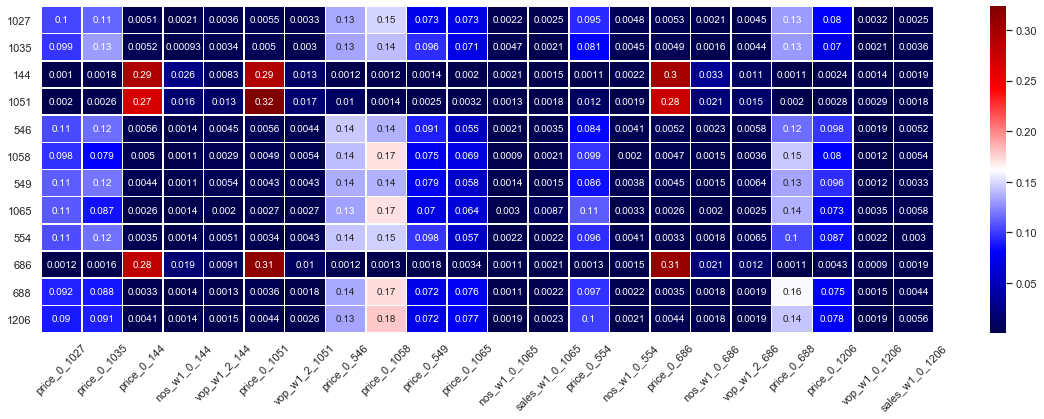

In [14]:
rt_imp=pd.DataFrame()
for i,r in sku.iterrows():    
    data=eval('skuf_'+i)
    for epoch in range(initial_epoch,data.shape[0]):
        Xtr = data.drop(columns=['t']).iloc[:epoch]
        ytr = data["t"].iloc[:epoch]
        forest = ExtraTreesRegressor(n_estimators=250, random_state=0)
        forest.fit(Xtr, ytr)
        if epoch==initial_epoch:
            rt_imp[i]=pd.Series(forest.feature_importances_,index=Xtr.columns)
        else:
            rt_imp[i]=rt_imp[i]+pd.Series(forest.feature_importances_,index=Xtr.columns)
    rt_imp[i]=rt_imp[i]/(data.shape[0]-initial_epoch)
f, ax = plt.subplots(figsize=(20, 6))
sns.heatmap(rt_imp.T,annot_kws={"size": 10},
            annot=True, linewidths=.5, ax=ax, cmap="seismic")
plt.yticks(rotation=0);
plt.xticks(rotation=45);

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5, 21.5]),
 <a list of 22 Text xticklabel objects>)

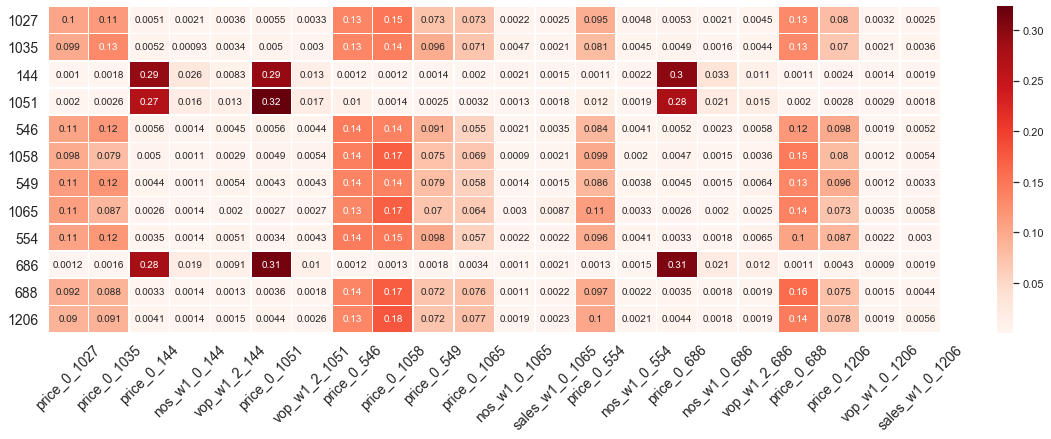

In [14]:
f, ax = plt.subplots(figsize=(20, 6))
sns.heatmap(rt_imp.T,annot_kws={"size": 10},
            annot=True, linewidths=.5, ax=ax, cmap="Reds")
plt.xlabel('',fontsize=18)
plt.ylabel('',fontsize=18,labelpad=40)
plt.yticks(fontsize=14,rotation=0)
plt.xticks(fontsize=14,rotation=45)

In [15]:
relevant_features2 = {k: [] for k in rt_imp.columns}
for sk in relevant_features2:
    for index,fi in rt_imp[sk].iteritems():
        if fi>.01:
            relevant_features2[sk].append(index)

In [16]:
relevant_features2={'1027': ['price_0_1027',
  'price_0_1035',
  'price_0_546',
  'price_0_1058',
  'price_0_549',
  'price_0_1065',
  'price_0_554',
  'price_0_688',
  'price_0_1206'],
 '1035': ['price_0_1027',
  'price_0_1035',
  'price_0_546',
  'price_0_1058',
  'price_0_549',
  'price_0_1065',
  'price_0_554',
  'price_0_688',
  'price_0_1206'],
 '144': ['price_0_144',
  'nos_w1_0_144',
  'price_0_1051',
  'vop_w1_2_1051',
  'price_0_686',
  'nos_w1_0_686',
  'vop_w1_2_686'],
 '1051': ['price_0_144',
  'nos_w1_0_144',
  'vop_w1_2_144',
  'price_0_1051',
  'vop_w1_2_1051',
  'price_0_546',
  'price_0_554',
  'price_0_686',
  'nos_w1_0_686',
  'vop_w1_2_686'],
 '546': ['price_0_1027',
  'price_0_1035',
  'price_0_546',
  'price_0_1058',
  'price_0_549',
  'price_0_1065',
  'price_0_554',
  'price_0_688',
  'price_0_1206'],
 '1058': ['price_0_1027',
  'price_0_1035',
  'price_0_546',
  'price_0_1058',
  'price_0_549',
  'price_0_1065',
  'price_0_554',
  'price_0_688',
  'price_0_1206'],
 '549': ['price_0_1027',
  'price_0_1035',
  'price_0_546',
  'price_0_1058',
  'price_0_549',
  'price_0_1065',
  'price_0_554',
  'price_0_688',
  'price_0_1206'],
 '1065': ['price_0_1027',
  'price_0_1035',
  'price_0_546',
  'price_0_1058',
  'price_0_549',
  'price_0_1065',
  'price_0_554',
  'price_0_688',
  'price_0_1206'],
 '554': ['price_0_1027',
  'price_0_1035',
  'price_0_546',
  'price_0_1058',
  'price_0_549',
  'price_0_1065',
  'price_0_554',
  'price_0_688',
  'price_0_1206'],
 '686': ['price_0_144',
  'nos_w1_0_144',
  'price_0_1051',
  'vop_w1_2_1051',
  'price_0_686',
  'nos_w1_0_686',
  'vop_w1_2_686'],
 '688': ['price_0_1027',
  'price_0_1035',
  'price_0_546',
  'price_0_1058',
  'price_0_549',
  'price_0_1065',
  'price_0_554',
  'price_0_688',
  'price_0_1206'],
 '1206': ['price_0_1027',
  'price_0_1035',
  'price_0_546',
  'price_0_1058',
  'price_0_549',
  'price_0_1065',
  'price_0_554',
  'price_0_688',
  'price_0_1206']}

In [18]:
initial_epoch=51
mapes_lr=[]
for i,r in sku.iterrows():
    data=eval('skuf_'+i)
    mapes=[]
    for epoch in range(initial_epoch,data.shape[0]):
        Xtr = data[relevant_features2[i]].iloc[:epoch]
        ytr = data["t"].iloc[:epoch]
        lr_model = LinearRegression()
        lr_model.fit(Xtr, ytr)

        Xp=data[relevant_features2[i]].iloc[epoch]
        yp = lr_model.predict(np.array(Xp).reshape(1, -1))

        ytrue=data["t"].iloc[epoch]
        mape=mean_absolute_percentage_error(ytrue, yp)
        mapes.append(mape)
    mapes_lr.append(np.mean(np.array(mapes)))
print(mapes_lr)

[19.09569196326357, 18.949104315465103, 19.532808338011236, 18.355367599799752, 17.86689837653132, 17.029165489274884, 22.59908949662407, 13.753818279759464, 17.828425447517127, 23.238665710757534, 15.820052277333588, 12.629568413499197]


In [19]:
initial_epoch=51
max_degree=6
seed=1234
alphas=np.geomspace(0.08,.4,8)
lp_mapes=[]
for i,r in sku.iterrows():
    data=eval('skuf_'+i)
    mape_p=[]
    for alpha in alphas:
        for degree in range(1,max_degree+1):
            mapes=[]
            for epoch in range(initial_epoch,data.shape[0]):
                X = data[relevant_features2[i]].iloc[:epoch]
                ytr = data["t"].iloc[:epoch]
                polynomial = PolynomialFeatures(degree=degree)
                Xtr = pd.DataFrame(polynomial.fit_transform(X),index=X.index)
                lasso_model = Lasso(alpha=alpha,max_iter=300,random_state=seed)
                lasso_model.fit(Xtr,ytr)
                coefs=lasso_model.coef_
                Xtest=np.array(data[relevant_features2[i]].iloc[epoch]).reshape(1, -1)      
                Xp=polynomial.fit_transform(Xtest)
                yp=lasso_model.predict(Xp)
                ytrue=data["t"].iloc[epoch]
                mapes.append(mean_absolute_percentage_error(ytrue, yp))
            mape_p.append(np.mean(np.array(mapes)))
    lp_mapes.append(np.min(np.array(mape_p)))
print(lp_mapes)

[14.028472358894483, 13.793179627737707, 13.35297388447366, 14.981747890085082, 13.254413318338377, 13.720256684379134, 14.945833019552515, 10.443062010118169, 10.733019141721385, 14.846485446756942, 12.217945221291115, 11.379613801505291]


In [20]:
initial_epoch=51
max_degree=6
seed=1234
alphas=np.geomspace(0.08,.4,8)
rp_mapes=[]
for i,r in sku.iterrows():
    data=eval('skuf_'+i)
    mape_p=[]
    for alpha in alphas:
        for degree in range(1,max_degree+1):
            mapes=[]
            for epoch in range(initial_epoch,data.shape[0]):
                X = data[relevant_features2[i]].iloc[:epoch]
                ytr = data["t"].iloc[:epoch]
                polynomial = PolynomialFeatures(degree=degree)
                Xtr = pd.DataFrame(polynomial.fit_transform(X),index=X.index)
                ridge_model = Ridge(alpha=alpha)
                ridge_model.fit(Xtr,ytr)
                coefs=ridge_model.coef_
                Xtest=np.array(data[relevant_features2[i]].iloc[epoch]).reshape(1, -1)      
                Xp=polynomial.fit_transform(Xtest)
                yp=ridge_model.predict(Xp)
                ytrue=data["t"].iloc[epoch]
                mapes.append(mean_absolute_percentage_error(ytrue, yp))
            mape_p.append(np.mean(np.array(mapes)))
    rp_mapes.append(np.min(np.array(mape_p)))
print(rp_mapes)

[12.668507148313997, 11.300977149413097, 17.921894619541806, 16.005030107465114, 13.1082926152762, 12.120239101538607, 13.57876629349928, 9.17372936976972, 10.594839881497743, 20.065174849117774, 10.639944666213436, 10.542069900108617]


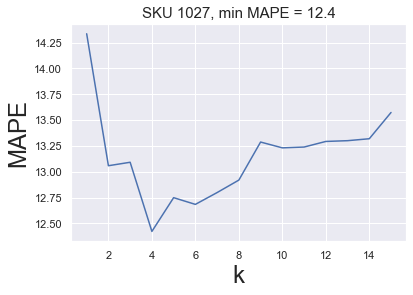

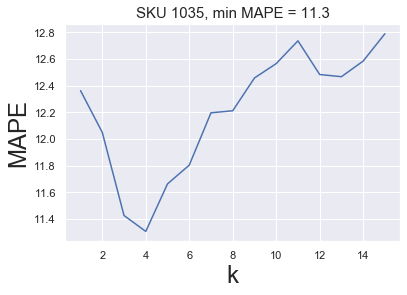

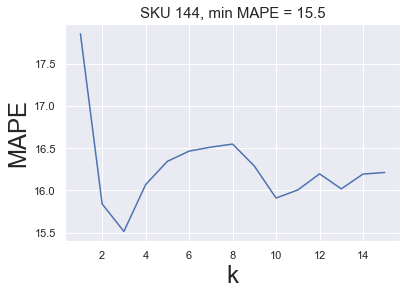

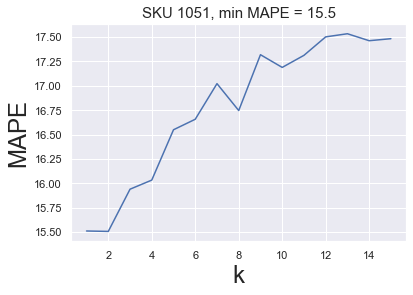

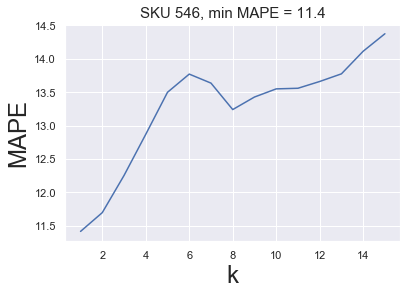

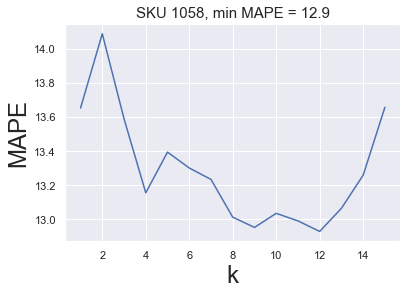

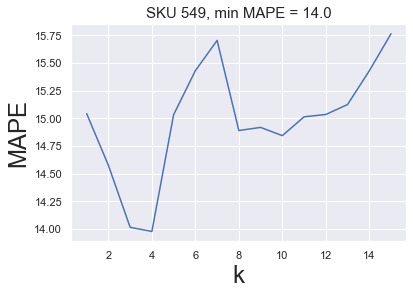

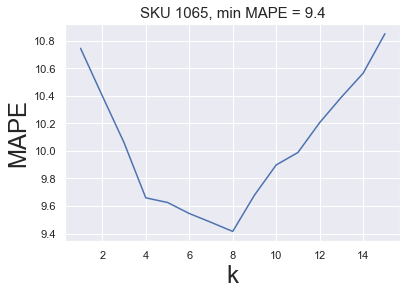

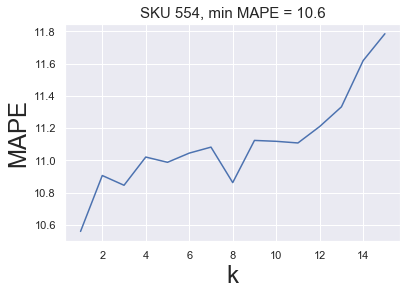

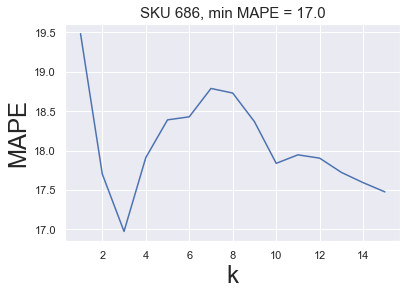

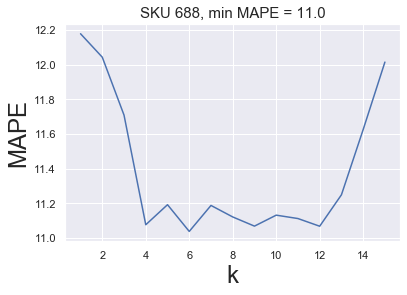

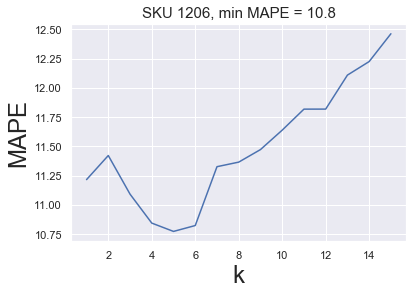

In [22]:
initial_epoch=51
max_k=15
seed=1234
k_values=range(1,max_k+1)
k_optimals=[]
mapes_knn=[]
for i,r in sku.iterrows():
    data=eval('skuf_'+i)
    mape_d=[]
    for k in k_values:
        mapes=[]
        for epoch in range(initial_epoch,data.shape[0]):
            Xtr = data[relevant_features2[i]].iloc[:epoch]
            ytr = data["t"].iloc[:epoch]
            Xtr_std = (Xtr-Xtr.mean())/Xtr.std()
            knn = neighbors.KNeighborsRegressor(k, weights='uniform')
            Xp=data[relevant_features2[i]].iloc[epoch] 
            Xp_std=(Xp-Xtr.mean())/Xtr.std()
            yp = knn.fit(Xtr_std, ytr).predict(np.array(Xp_std).reshape(1, -1))
            
            ytrue=data["t"].iloc[epoch]
            mapes.append(mean_absolute_percentage_error(ytrue, yp))
        mape_d.append(np.mean(np.array(mapes)))
    mape_d=np.array(mape_d)
    k_optimals.append(k_values[np.argmin(mape_d)])
    mapes_knn.append(np.min(mape_d))
    plt.figure()
    plt.plot(k_values,mape_d)
    plt.ylabel('MAPE')
    plt.xlabel('k')
    plt.grid()
    plt.title('SKU '+i+', min MAPE = '+str(round(np.min(mape_d),1)),fontsize=15)
    plt.show()

In [21]:
(Xp-Xtr.mean())/Xtr.std()

price_0_1027    0.801254
price_0_1035    0.846261
price_0_546     1.139425
price_0_1058    0.812153
price_0_549     0.839855
price_0_1065    0.681773
price_0_554     0.755691
price_0_688     0.791106
price_0_1206    0.725421
dtype: float64

<Figure size 432x288 with 0 Axes>

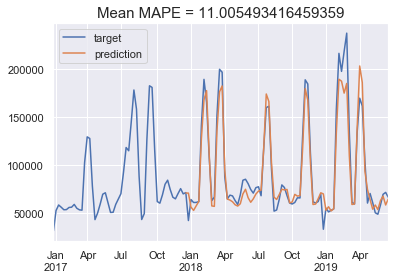

<Figure size 432x288 with 0 Axes>

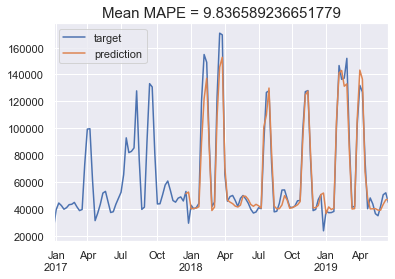

<Figure size 432x288 with 0 Axes>

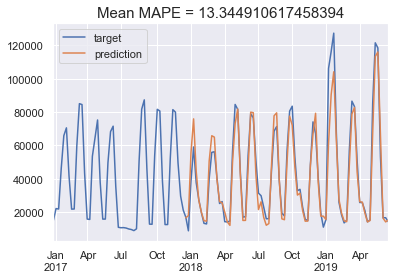

<Figure size 432x288 with 0 Axes>

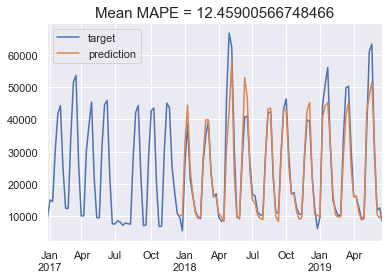

<Figure size 432x288 with 0 Axes>

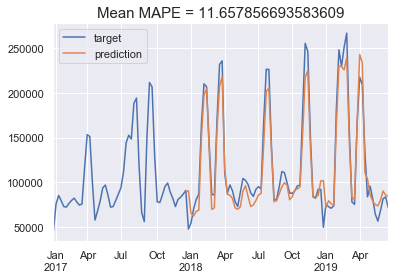

<Figure size 432x288 with 0 Axes>

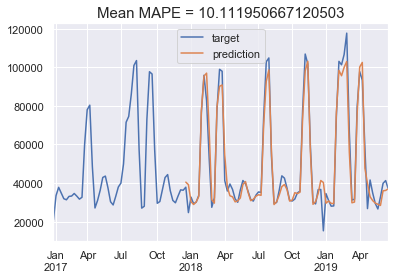

<Figure size 432x288 with 0 Axes>

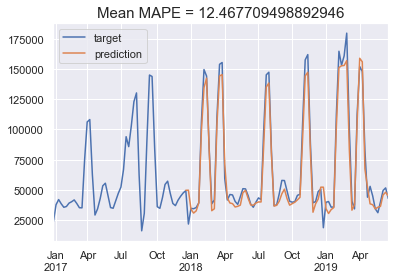

<Figure size 432x288 with 0 Axes>

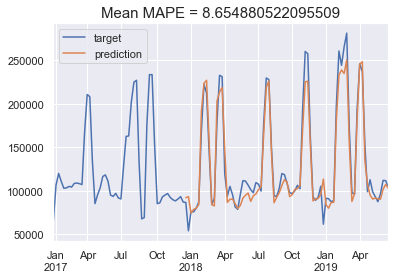

<Figure size 432x288 with 0 Axes>

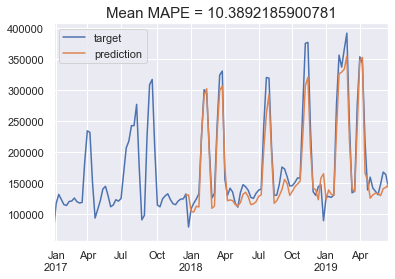

<Figure size 432x288 with 0 Axes>

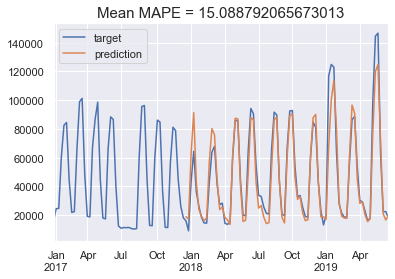

<Figure size 432x288 with 0 Axes>

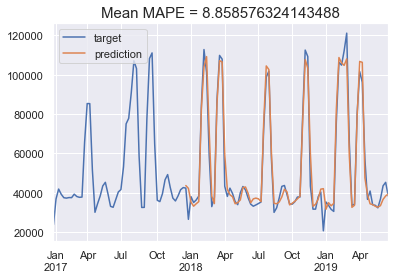

<Figure size 432x288 with 0 Axes>

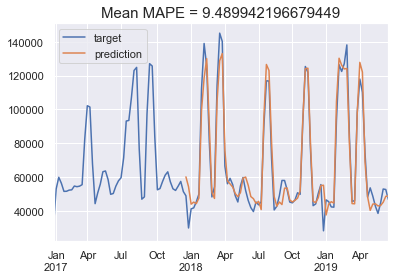

In [22]:
initial_epoch=51
seed=84984
mapes_rf=[]
for i,r in sku.iterrows():
    data=eval('skuf_'+i)
    mapes=[]
    y_prediction=pd.DataFrame({'target':data["t"].copy(),'prediction':np.ones((data.shape[0]))*np.nan})
    for epoch in range(initial_epoch,data.shape[0]):
        Xtr = data[data.drop(columns=['t']).columns].iloc[:epoch]
        ytr = data["t"].iloc[:epoch]

        
        forest = RandomForestRegressor(n_estimators=500, random_state=seed)
        forest.fit(Xtr, ytr)

        Xp=data[data.drop(columns=['t']).columns].iloc[epoch]
        yp = forest.predict(np.array(Xp).reshape(1, -1))
        y_prediction.iloc[epoch]['prediction']=yp[0]
        ytrue=data["t"].iloc[epoch]
        mape=mean_absolute_percentage_error(ytrue, yp)
        mapes.append(mape)
    mapes_rf.append(np.mean(np.array(mapes)))
    plt.figure()
    ax=y_prediction.plot()
    ax.set_xlabel("")
    plt.title('Mean MAPE = '+str(np.mean(np.array(mapes))),fontsize=15)
    plt.grid()
    plt.show()

In [23]:
mapes_rf

[11.005493416459359,
 9.836589236651779,
 13.344910617458394,
 12.45900566748466,
 11.657856693583609,
 10.111950667120503,
 12.467709498892946,
 8.654880522095509,
 10.3892185900781,
 15.088792065673013,
 8.858576324143488,
 9.489942196679449]

<Figure size 432x288 with 0 Axes>

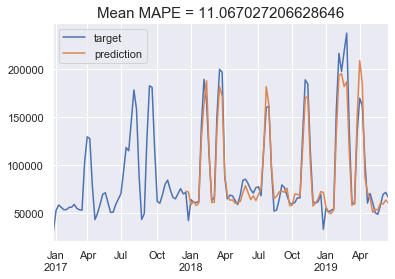

<Figure size 432x288 with 0 Axes>

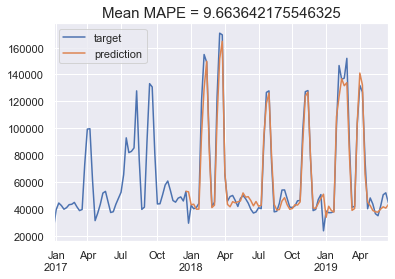

<Figure size 432x288 with 0 Axes>

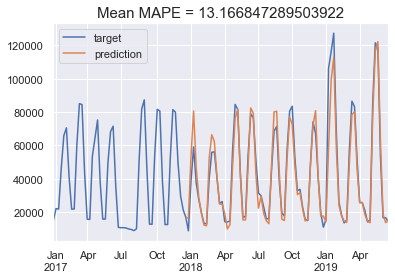

<Figure size 432x288 with 0 Axes>

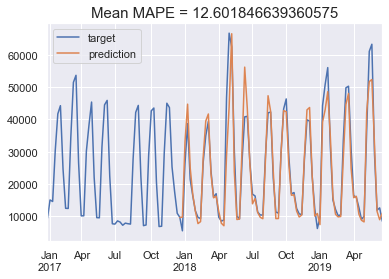

<Figure size 432x288 with 0 Axes>

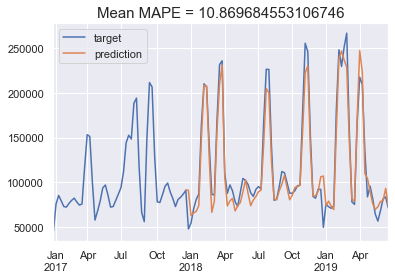

<Figure size 432x288 with 0 Axes>

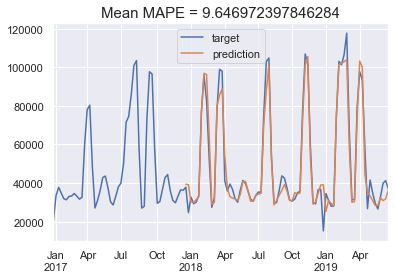

<Figure size 432x288 with 0 Axes>

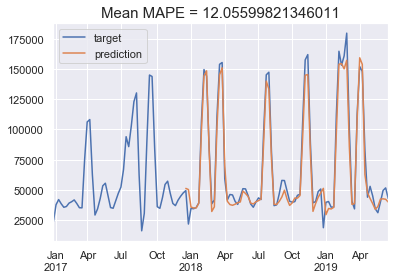

<Figure size 432x288 with 0 Axes>

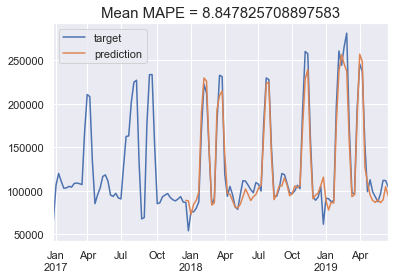

<Figure size 432x288 with 0 Axes>

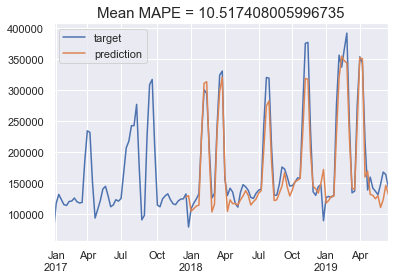

<Figure size 432x288 with 0 Axes>

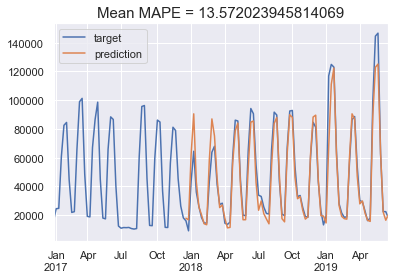

<Figure size 432x288 with 0 Axes>

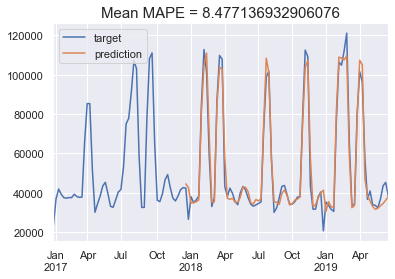

<Figure size 432x288 with 0 Axes>

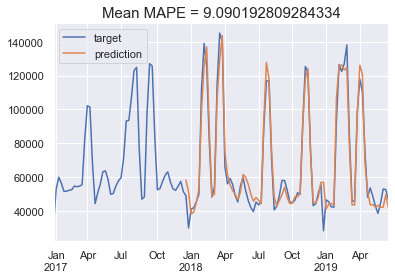

In [24]:
initial_epoch=51
seed=84984
mapes_xrf=[]
for i,r in sku.iterrows():
    data=eval('skuf_'+i)
    mapes=[]
    y_prediction=pd.DataFrame({'target':data["t"].copy(),'prediction':np.ones((data.shape[0]))*np.nan})
    for epoch in range(initial_epoch,data.shape[0]):
        Xtr = data[data.drop(columns=['t']).columns].iloc[:epoch]
        ytr = data["t"].iloc[:epoch]

        
        forest = ExtraTreesRegressor(n_estimators=500, random_state=seed)
        forest.fit(Xtr, ytr)

        Xp=data[data.drop(columns=['t']).columns].iloc[epoch]
        yp = forest.predict(np.array(Xp).reshape(1, -1))
        y_prediction.iloc[epoch]['prediction']=yp[0]
        ytrue=data["t"].iloc[epoch]
        mape=mean_absolute_percentage_error(ytrue, yp)
        mapes.append(mape)
    mapes_xrf.append(np.mean(np.array(mapes)))
    plt.figure()
    ax=y_prediction.plot()
    ax.set_xlabel("")
    plt.title('Mean MAPE = '+str(np.mean(np.array(mapes))),fontsize=15)
    plt.grid()
    plt.show()

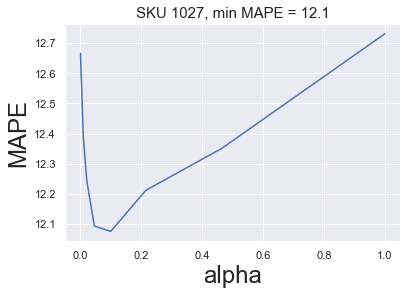

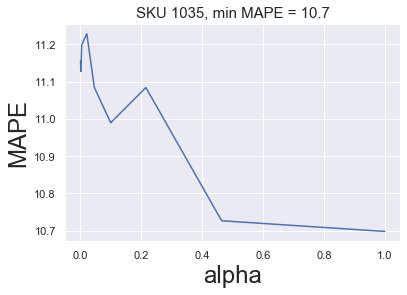

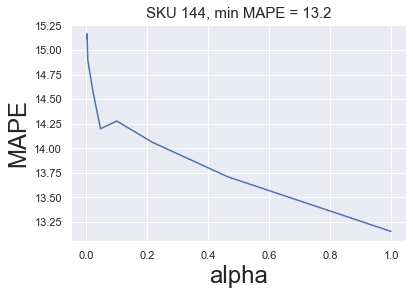

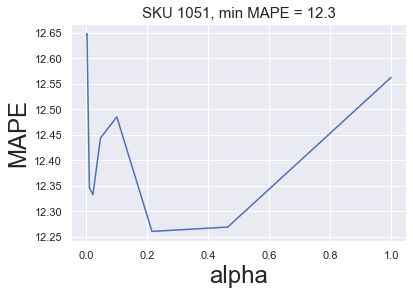

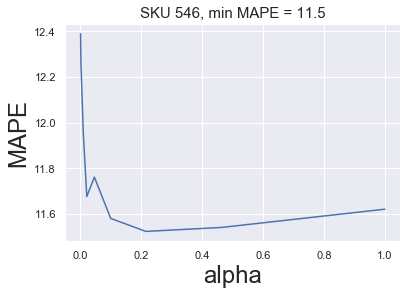

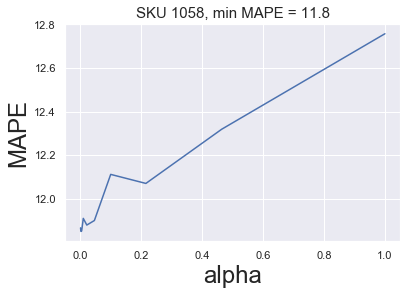

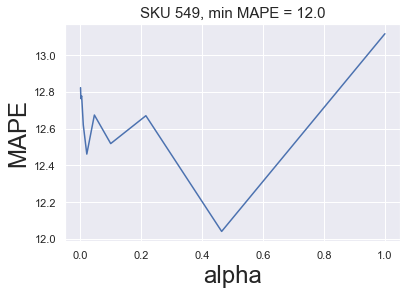

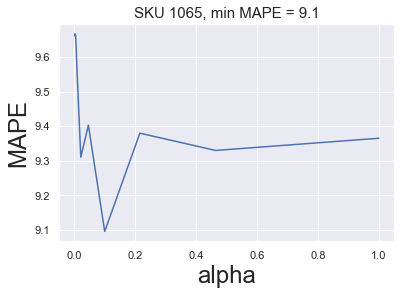

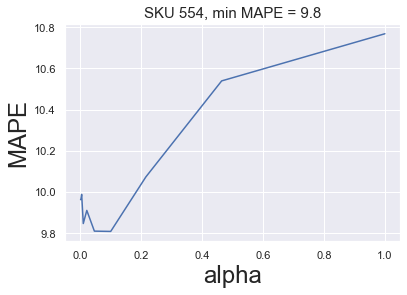

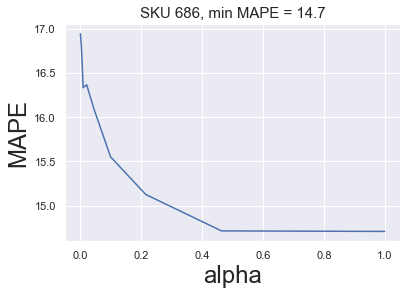

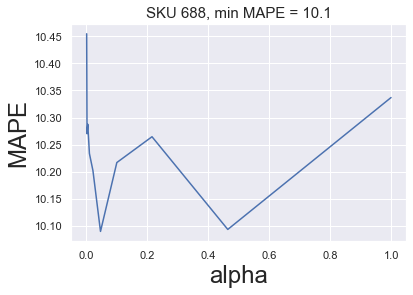

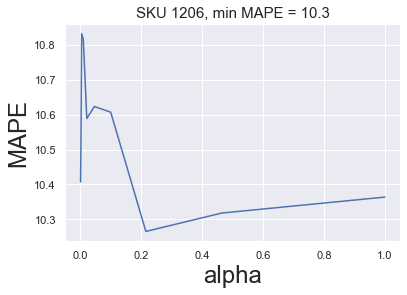

In [35]:
initial_epoch=51
max_k=10
seed=1234
ab_mapes=[]
alphas=np.geomspace(0.001,1,10)
for i,r in sku.iterrows():
    data=eval('skuf_'+i)
    
    mape_a=[]
    for alpha in alphas:
        mapes=[]
        
        for epoch in range(initial_epoch,data.shape[0]):
            Xtr = data[relevant_features2[i]].iloc[:epoch]
            ytr = data["t"].iloc[:epoch]


            AB_regr = AdaBoostRegressor(random_state=348, n_estimators=500,
                                       learning_rate=alpha)
            AB_regr.fit(Xtr, ytr)

            Xp=data[relevant_features2[i]].iloc[epoch]
            yp = AB_regr.predict(np.array(Xp).reshape(1, -1))

            ytrue=data["t"].iloc[epoch]
            mape=mean_absolute_percentage_error(ytrue, yp)
            mapes.append(mape)
        mape_a.append(np.mean(np.array(mapes)))
    ab_mapes.append(np.min(np.array(mape_a)))
    plt.figure()
    plt.plot(alphas,np.array(mape_a))
    plt.ylabel('MAPE')
    plt.xlabel('alpha')
    plt.grid()
    plt.title('SKU '+i+', min MAPE = '+str(round(np.min(np.array(mape_a)),1)),fontsize=15)
    plt.show()

In [37]:
initial_epoch=51
gb_mapes=[]
alphas=np.geomspace(0.005,.35,10)
depths=np.array([5,6,7,8,9])
parameters=np.array(np.meshgrid(alphas,depths)).T.reshape(-1,2)
for i,r in sku.iterrows():
    data=eval('skuf_'+i)
    
    mape_a=[]
    for param in parameters:
        mapes=[]
        
        for epoch in range(initial_epoch,data.shape[0]):
            Xtr = data[relevant_features2[i]].iloc[:epoch]
            ytr = data["t"].iloc[:epoch]

            GB_regr = GradientBoostingRegressor(random_state=348, n_estimators=500,
                                               learning_rate = param[0],
                                                max_depth = int(param[1]))
            GB_regr.fit(Xtr, ytr)

            Xp=data[relevant_features2[i]].iloc[epoch]
            yp = GB_regr.predict(np.array(Xp).reshape(1, -1))

            ytrue=data["t"].iloc[epoch]

            mape=mean_absolute_percentage_error(ytrue, yp)
            mapes.append(mape)
        mape_a.append(np.mean(np.array(mapes)))
    gb_mapes.append(np.min(np.array(mape_a)))
#     plt.figure()
#     plt.plot(alphas,np.array(mape_a))
#     plt.ylabel('MAPE')
#     plt.xlabel('alpha')
#     plt.grid()
#     plt.title('SKU '+i+', min MAPE = '+str(round(np.min(np.array(mape_a)),1)),fontsize=15)
#     plt.show()
    

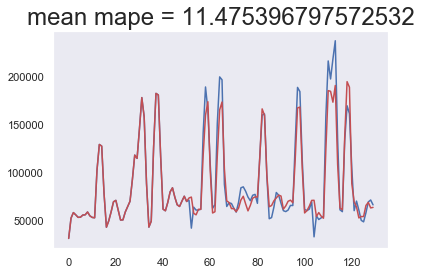

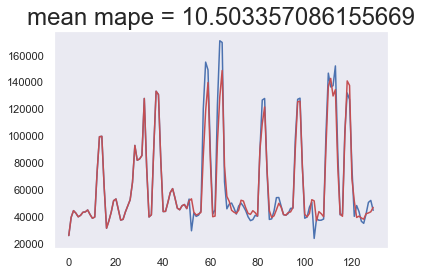

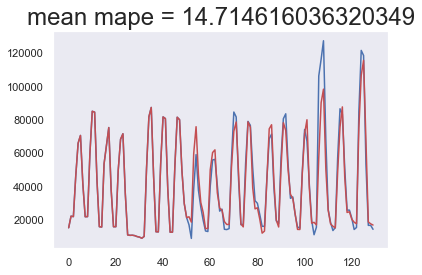

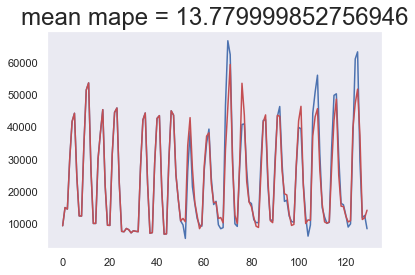

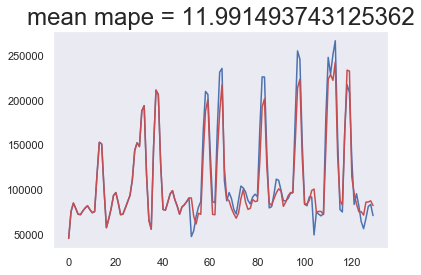

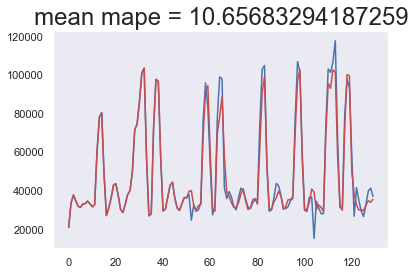

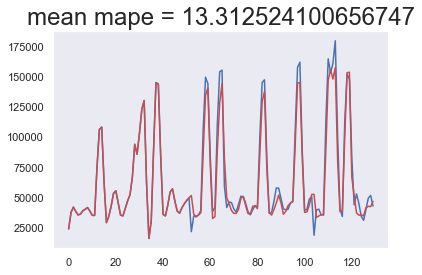

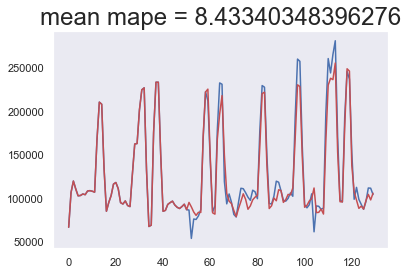

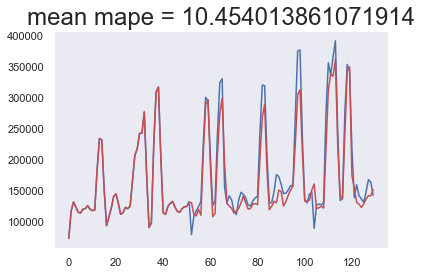

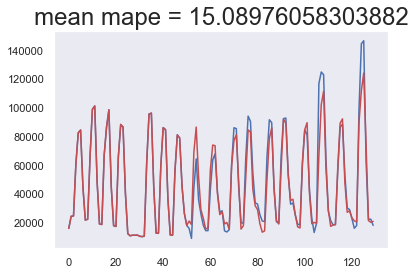

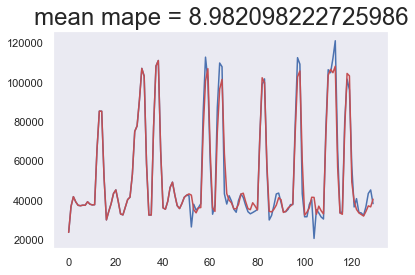

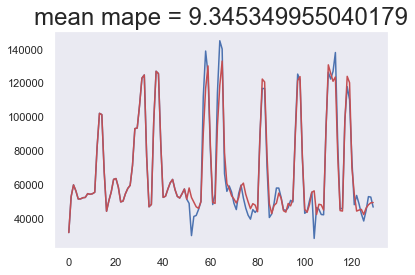

In [30]:
initial_epoch=51
max_k=10
seed=1234
for i,r in sku.iterrows():
    data=eval('skuf_'+i)
    mapes=[]
    y_prediction=data["t"].copy()
    for epoch in range(initial_epoch,data.shape[0]):
        Xtr = data[data.drop(columns=['t']).columns].iloc[:epoch]
        ytr = data["t"].iloc[:epoch]


        CB_regr = CatBoostRegressor(iterations=500,learning_rate=0.03,
                                    logging_level='Silent')
        CB_regr.fit(Xtr, ytr)

        Xp=data[data.drop(columns=['t']).columns].iloc[epoch]
        yp = CB_regr.predict(np.array(Xp).reshape(1, -1))
        y_prediction.iloc[epoch]=yp[0]
        ytrue=data["t"].iloc[epoch]
        mape=mean_absolute_percentage_error(ytrue, yp)
        mapes.append(mape)
    plt.figure()
    plt.plot(np.array(data["t"]),'b')
    plt.plot(np.array(y_prediction),'r')
    plt.title('mean mape = '+str(np.mean(np.array(mapes))))
    plt.show()

In [97]:
alphas=np.geomspace(0.001,.2,10)
colsamples=np.linspace(0.3,0.4,10)
depths=np.array([5,6,7])
np.array(np.meshgrid(alphas,colsamples,depths)).T.reshape(-1,3)

array([[1.00000000e-03, 3.00000000e-01, 4.00000000e+00],
       [1.00000000e-03, 3.11111111e-01, 4.00000000e+00],
       [1.00000000e-03, 3.22222222e-01, 4.00000000e+00],
       [1.00000000e-03, 3.33333333e-01, 4.00000000e+00],
       [1.00000000e-03, 3.44444444e-01, 4.00000000e+00],
       [1.00000000e-03, 3.55555556e-01, 4.00000000e+00],
       [1.00000000e-03, 3.66666667e-01, 4.00000000e+00],
       [1.00000000e-03, 3.77777778e-01, 4.00000000e+00],
       [1.00000000e-03, 3.88888889e-01, 4.00000000e+00],
       [1.00000000e-03, 4.00000000e-01, 4.00000000e+00],
       [1.80164823e-03, 3.00000000e-01, 4.00000000e+00],
       [1.80164823e-03, 3.11111111e-01, 4.00000000e+00],
       [1.80164823e-03, 3.22222222e-01, 4.00000000e+00],
       [1.80164823e-03, 3.33333333e-01, 4.00000000e+00],
       [1.80164823e-03, 3.44444444e-01, 4.00000000e+00],
       [1.80164823e-03, 3.55555556e-01, 4.00000000e+00],
       [1.80164823e-03, 3.66666667e-01, 4.00000000e+00],
       [1.80164823e-03, 3.77777

In [106]:
initial_epoch=51
alphas=np.geomspace(0.008,.3,8)
colsamples=np.linspace(0.25,0.4,4)
depths=np.array([5,6,7,8])
parameters=np.array(np.meshgrid(alphas,colsamples,depths)).T.reshape(-1,3)
xgb_optimal_alphas=[]
min_mapes=[]
for i,r in sku.iterrows():
    data=eval('skuf_'+i)
    
    mape_a=[]
    for param in parameters:
        mapes=[]
        for epoch in range(initial_epoch,data.shape[0]):
            Xtr = data[data.drop(columns=['t']).columns].iloc[:epoch]
            ytr = data["t"].iloc[:epoch]  

            XG_regr = xgb.XGBRegressor(colsample_bytree = param[1], learning_rate = param[0],
                max_depth = int(param[2]), n_estimators = 500)

            XG_regr.fit(np.array(Xtr),np.array(ytr))

            Xp=data[data.drop(columns=['t']).columns].iloc[epoch]
            Xp=np.array(Xp).reshape(1, -1)

            yp = XG_regr.predict(Xp)
            ytrue=data["t"].iloc[epoch]

            mape=mean_absolute_percentage_error(ytrue, yp)
            mapes.append(mape)
        mape_a.append(np.mean(np.array(mapes)))
    xgb_optimal_alphas.append(parameters[np.argmin(np.array(mape_a))])
#     plt.figure()
#     plt.plot(alphas,np.array(mape_a))
#     plt.ylabel('MAPE')
#     plt.xlabel('alpha')
#     plt.grid()
    print(xgb_optimal_alphas[len(xgb_optimal_alphas)-1])
    print(np.min(np.array(mape_a)))
    min_mapes.append(np.min(np.array(mape_a)))
#     plt.title('SKU '+i+', min MAPE = '+str(round(np.min(np.array(mape_a)),1)),fontsize=15)
#     plt.show()
    

[0.10651188 0.4        8.        ]
10.514749399433502
[0.1787556 0.35      6.       ]
9.403646040926658
[0.0225327 0.4       5.       ]
13.993660008676256
[0.0225327 0.4       8.       ]
13.223055622332636
[0.0225327 0.4       5.       ]
10.262838079258092
[0.03781593 0.35       8.        ]
9.53095097015936
[0.06346531 0.25       6.        ]
11.952875070885424
[0.10651188 0.25       5.        ]
8.489111444877484
[0.10651188 0.25       8.        ]
9.566036738839172
[0.3 0.4 8. ]
13.666942958053957
[0.01342615 0.3        6.        ]
8.289255467803464
[0.008 0.25  6.   ]
8.453115677944373


In [41]:
xgb_optimal_params=[np.array([0.10651188, 0.4       , 8.        ]),
 np.array([0.1787556, 0.35     , 6.       ]),
 np.array([0.0225327, 0.45      , 5.       ]),
 np.array([0.0225327, 0.4      , 8.       ]),
 np.array([0.0225327, 0.4      , 5.       ]),
 np.array([0.03781593, 0.35      , 8.        ]),
 np.array([0.06346531, 0.25      , 6.        ]),
 np.array([0.10651188, 0.25      , 5.        ]),
 np.array([0.10651188, 0.25      , 8.        ]),
 np.array([0.3, 0.45, 8. ]),
 np.array([0.01342615, 0.3       , 6.        ]),
 np.array([0.008, 0.25 , 6.   ])]

<Figure size 432x288 with 0 Axes>

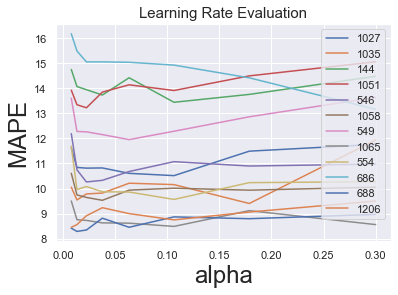

In [185]:
initial_epoch=51
alphas=np.geomspace(0.008,.3,8)
colsamples=np.linspace(0.25,0.4,4)
depths=np.array([5,6,7,8])
alpha_df=pd.DataFrame(index=alphas)
cont=-1
for i,r in sku.iterrows():
    cont+=1
    data=eval('skuf_'+i)
    
    mape_a=[]
    for alpha in alphas:
        mapes=[]
        for epoch in range(initial_epoch,data.shape[0]):
            Xtr = data[data.drop(columns=['t']).columns].iloc[:epoch]
            ytr = data["t"].iloc[:epoch]  

            XG_regr = xgb.XGBRegressor(colsample_bytree = xgb_optimal_params[cont][1],
                                   learning_rate = alpha,
            max_depth = int(xgb_optimal_params[cont][2]), n_estimators = 500)

            XG_regr.fit(np.array(Xtr),np.array(ytr))

            Xp=data[data.drop(columns=['t']).columns].iloc[epoch]
            Xp=np.array(Xp).reshape(1, -1)

            yp = XG_regr.predict(Xp)
            ytrue=data["t"].iloc[epoch]

            mape=mean_absolute_percentage_error(ytrue, yp)
            mapes.append(mape)
        mape_a.append(np.mean(np.array(mapes)))
    alpha_df[i]=pd.Series(np.array(mape_a),index=alphas)
plt.figure()
alpha_df.plot()
plt.ylabel('MAPE')
plt.xlabel('alpha')
plt.grid()
plt.title('Learning Rate Evaluation',fontsize=15)
plt.show()

<Figure size 432x288 with 0 Axes>

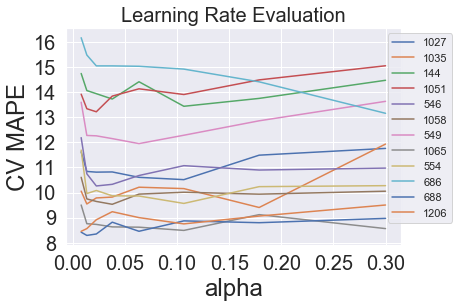

In [298]:
plt.figure()
alpha_df.plot()
plt.ylabel('CV MAPE')
plt.xlabel('alpha')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid()
plt.legend(loc='upper right',bbox_to_anchor=[1.17,1])
plt.title('Learning Rate Evaluation',fontsize=20)
plt.show()

<Figure size 432x288 with 0 Axes>

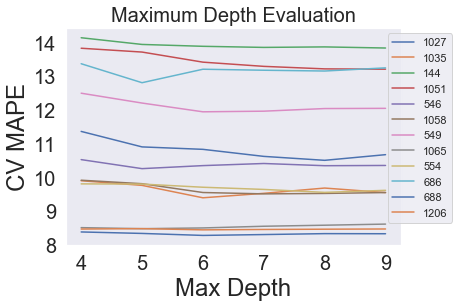

In [303]:
initial_epoch=51
alphas=np.geomspace(0.008,.3,8)
colsamples=np.linspace(0.25,0.4,4)
depths=np.array([4,5,6,7,8,9])
depths_df=pd.DataFrame(index=depths)
cont=-1
for i,r in sku.iterrows():
    cont+=1
    data=eval('skuf_'+i)
    
    mape_a=[]
    for depth in depths:
        mapes=[]
        for epoch in range(initial_epoch,data.shape[0]):
            Xtr = data[data.drop(columns=['t']).columns].iloc[:epoch]
            ytr = data["t"].iloc[:epoch]  

            XG_regr = xgb.XGBRegressor(colsample_bytree = xgb_optimal_params[cont][1],
                                   learning_rate = xgb_optimal_params[cont][0],
            max_depth = int(depth), n_estimators = 500)

            XG_regr.fit(np.array(Xtr),np.array(ytr))

            Xp=data[data.drop(columns=['t']).columns].iloc[epoch]
            Xp=np.array(Xp).reshape(1, -1)

            yp = XG_regr.predict(Xp)
            ytrue=data["t"].iloc[epoch]

            mape=mean_absolute_percentage_error(ytrue, yp)
            mapes.append(mape)
        mape_a.append(np.mean(np.array(mapes)))
    depths_df[i]=pd.Series(np.array(mape_a),index=depths)
plt.figure()
depths_df.plot()
plt.ylabel('CV MAPE')
plt.xlabel('Max Depth')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid()
plt.legend(loc='upper right',bbox_to_anchor=[1.17,1])
plt.grid()
plt.title('Maximum Depth Evaluation',fontsize=20)
plt.show()

<Figure size 432x288 with 0 Axes>

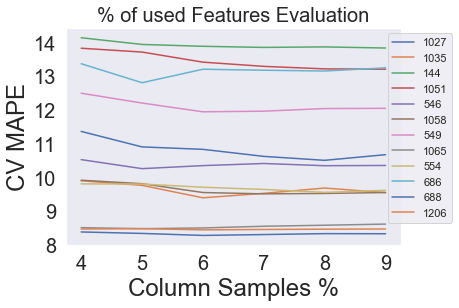

In [311]:
initial_epoch=51
alphas=np.geomspace(0.008,.3,8)
colsamples=np.linspace(0.2,0.5,7)
depths=np.array([4,5,6,7,8,9])
colsamples_df=pd.DataFrame(index=colsamples)
cont=-1
for i,r in sku.iterrows():
    cont+=1
    data=eval('skuf_'+i)
    
    mape_a=[]
    for cs in colsamples:
        mapes=[]
        for epoch in range(initial_epoch,data.shape[0]):
            Xtr = data[data.drop(columns=['t']).columns].iloc[:epoch]
            ytr = data["t"].iloc[:epoch]  

            XG_regr = xgb.XGBRegressor(colsample_bytree = cs,
                                   learning_rate = xgb_optimal_params[cont][0],
            max_depth = int(xgb_optimal_params[cont][2]), n_estimators = 500)

            XG_regr.fit(np.array(Xtr),np.array(ytr))

            Xp=data[data.drop(columns=['t']).columns].iloc[epoch]
            Xp=np.array(Xp).reshape(1, -1)

            yp = XG_regr.predict(Xp)
            ytrue=data["t"].iloc[epoch]

            mape=mean_absolute_percentage_error(ytrue, yp)
            mapes.append(mape)
        mape_a.append(np.mean(np.array(mapes)))
    colsamples_df[i]=pd.Series(np.array(mape_a),index=colsamples)
plt.figure()
depths_df.plot()
plt.ylabel('CV MAPE')
plt.xlabel('Column Samples %')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid()
plt.legend(loc='upper right',bbox_to_anchor=[1.17,1])
plt.grid()
plt.title('% of used Features Evaluation',fontsize=20)
plt.show()

In [38]:


def tryXGBoostparams(parameters,sku_list):
    initial_epoch=51
    xgb_optimal_alphas=[]
    mape_list=[]
    cont=-1
    for i in sku_list:
        cont+=1
        data=eval('skuf_'+i)

        mape_a=[]
        mapes=[]
        for epoch in range(initial_epoch,data.shape[0]):
            Xtr = data[data.drop(columns=['t']).columns].iloc[:epoch]
            ytr = data["t"].iloc[:epoch]  

            XG_regr = xgb.XGBRegressor(colsample_bytree = parameters[cont,1], learning_rate = parameters[cont,0],
                max_depth = int(parameters[cont,2]), n_estimators = 500)

            XG_regr.fit(np.array(Xtr),np.array(ytr))

            Xp=data[data.drop(columns=['t']).columns].iloc[epoch]
            Xp=np.array(Xp).reshape(1, -1)

            yp = XG_regr.predict(Xp)
            ytrue=data["t"].iloc[epoch]

            mape=mean_absolute_percentage_error(ytrue, yp)
            mapes.append(mape)
        mean_mape=np.mean(np.array(mapes))
    #     xgb_optimal_alphas.append(parameters[np.argmin(np.array(mape_a))])
    #     plt.figure()
    #     plt.plot(alphas,np.array(mape_a))
    #     plt.ylabel('MAPE')
    #     plt.xlabel('alpha')
    #     plt.grid()
    #     print(xgb_optimal_alphas[len(xgb_optimal_alphas)-1])
        mape_list.append(mean_mape)
        print(mean_mape)
    return mape_list
    #     plt.title('SKU '+i+', min MAPE = '+str(round(np.min(np.array(mape_a)),1)),fontsize=15)
    #     plt.show()


In [43]:
min_mapes=tryXGBoostparams(np.array(xgb_optimal_params),sku.index.tolist())

10.514602216721006
9.403646040926658
13.950120432882958
13.225634738838277
10.268023607020467
9.532844088971615
11.952875070885424
8.488289209353868
9.564185231817957
13.16193519602235
8.28836142167278
8.453115677944373


In [124]:
initial_epoch=51
sku_list=['1027','1051','1058','554','686']
parameters=np.array([[0.10651188, 0.4       , 9.        ],
       [0.0225327 , 0.4       , 9.        ],
       [0.03781593, 0.35      , 9.        ],
       [0.10651188, 0.25      , 9.        ],
       [0.3       , 0.4       , 9.        ]])
min_mapes2=tryXGBoostparams(parameters,sku_list)

10.6822972546392
13.21670904172042
9.55904725102024
9.624935869463496
13.747665071676675


In [171]:
sku_list=['1027','144','1051','546','686']
parameters=np.array([[0.10651188, 0.45       , 8.        ],
       [0.0225327, 0.45      , 5.       ],
       [0.0225327, 0.45      , 8.       ],
       [0.0225327, 0.45      , 5.       ],
       [0.3, 0.45, 8. ]])
min_mapes2=tryXGBoostparams(parameters,sku_list)

10.666979545185082
13.950120432882958
13.346766523686767
10.590311561569665
13.16193519602235


In [135]:
sku_list=['1206','1206','1206','1206']
parameters=np.array([[0.008, 0.25 , 6.   ],
                    [0.007, 0.25 , 6.   ],
                    [0.008, 0.2 , 6.   ],
                    [0.008, 0.25 , 5.   ]])
min_mapes2=tryXGBoostparams(parameters,sku_list)

8.453115677944373
8.790811995203502
8.561794216231785
8.489305812193528


In [122]:
sku_list=['1027','1051','1058','554','686']
parameters=np.array([[0.10651188, 0.4       , 9.        ],
       [0.0225327 , 0.4       , 9.        ],
       [0.03781593, 0.35      , 9.        ],
       [0.10651188, 0.25      , 9.        ],
       [0.3       , 0.4       , 9.        ]])
min_mapes2=tryXGBoostparams(parameters,sku_list)

[0.10651188 0.4        9.        ]
3.8147248327732086
[0.10651188 0.4        9.        ]
0.31289716716855764
[0.10651188 0.4        9.        ]
1.494847983121872
[0.10651188 0.4        9.        ]
2.7577806264162064
[0.10651188 0.4        9.        ]
10.493945330381393


In [286]:
sku_list=['686','686','686','686','686']
parameters=np.array([[0.3, 0.45, 8. ],
       [0.31, 0.45, 8. ],
       [0.4, 0.45, 8. ],
       [0.3, 0.45, 9. ],
       [0.3, 0.5, 8. ]])
min_mapes2=tryXGBoostparams(parameters,sku_list)

13.16193519602235
13.66079169346898
14.846076200792826
13.255386484810446
14.349261625328019


<Figure size 432x288 with 0 Axes>

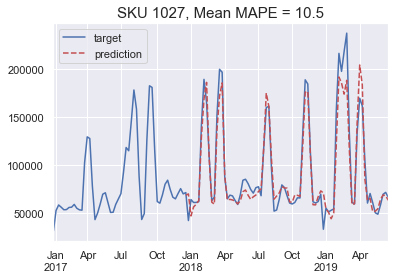

<Figure size 432x288 with 0 Axes>

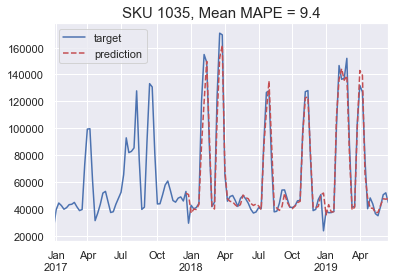

<Figure size 432x288 with 0 Axes>

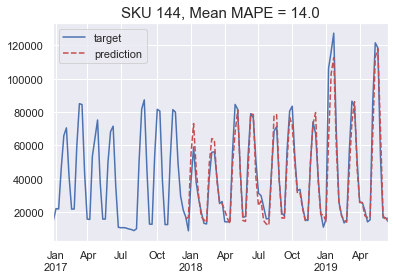

<Figure size 432x288 with 0 Axes>

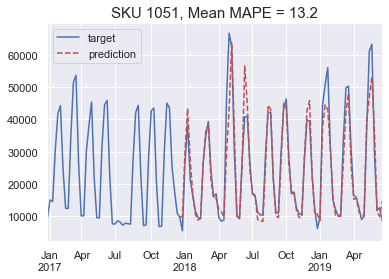

<Figure size 432x288 with 0 Axes>

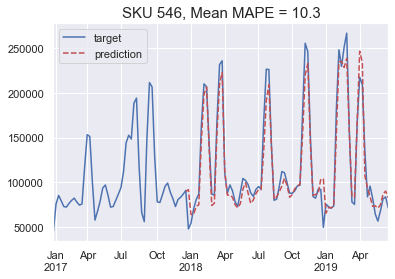

<Figure size 432x288 with 0 Axes>

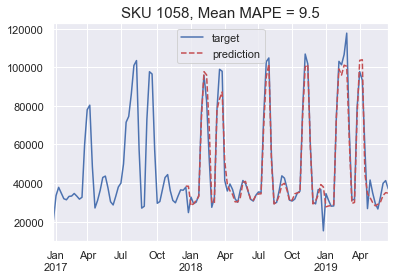

<Figure size 432x288 with 0 Axes>

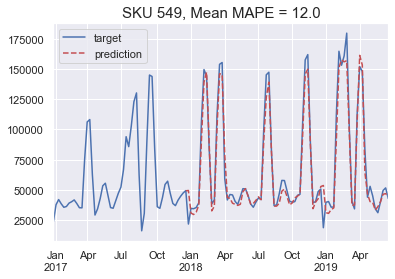

<Figure size 432x288 with 0 Axes>

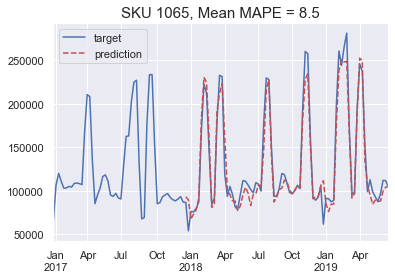

<Figure size 432x288 with 0 Axes>

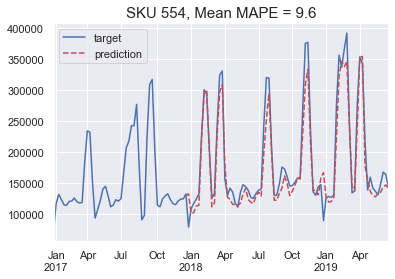

<Figure size 432x288 with 0 Axes>

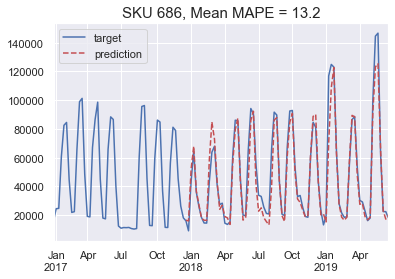

<Figure size 432x288 with 0 Axes>

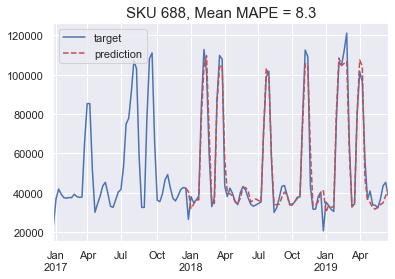

<Figure size 432x288 with 0 Axes>

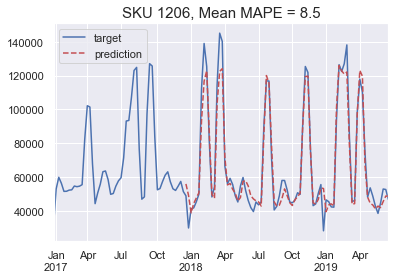

In [142]:
initial_epoch=51
cont=0
min_mapes=[]
for i,r in sku.iterrows():
    data=eval('skuf_'+i)
    
    mape_a=[]
    y_prediction=pd.DataFrame({'target':data["t"].copy(),'prediction':np.ones((data.shape[0]))*np.nan})
    mapes=[]
    for epoch in range(initial_epoch,data.shape[0]):
        Xtr = data[data.drop(columns=['t']).columns].iloc[:epoch]
        ytr = data["t"].iloc[:epoch]  

        XG_regr = xgb.XGBRegressor(colsample_bytree = xgb_optimal_params[cont][1],
                                   learning_rate = float(xgb_optimal_params[cont][0]),
            max_depth = int(xgb_optimal_params[cont][2]), n_estimators = 500)

        XG_regr.fit(np.array(Xtr),np.array(ytr))

        Xp=data[data.drop(columns=['t']).columns].iloc[epoch]
        Xp=np.array(Xp).reshape(1, -1)

        yp = XG_regr.predict(Xp)
        y_prediction.iloc[epoch]['prediction']=yp[0]
        ytrue=data["t"].iloc[epoch]

        mape=mean_absolute_percentage_error(ytrue, yp)
        mapes.append(mape)
    mape_a.append(np.mean(np.array(mapes)))
    cont+=1
    plt.figure()
    ax=y_prediction.plot(style=['b','r--'])
    ax.set_xlabel("")
    min_mapes.append(np.mean(np.array(mapes)))
    plt.title('SKU '+i+', Mean MAPE = '+str(round(np.mean(np.array(mapes)),1)),fontsize=15)
    plt.grid()
    plt.show()

In [24]:
mapes_lr=[19.095692,18.949104,19.532808,18.355368,17.866898,17.029165,22.599089,13.753818,17.828425,23.238666,15.820052,12.629568]
lp_mapes=[14.028472,13.79318,13.352974,14.981748,13.254413,13.720257,14.945833,10.443062,10.733019,14.846485,12.217945,11.379614]
rp_mapes=[12.668507,11.300977,17.921895,16.00503,13.108293,12.120239,13.578766,9.173729,10.59484,20.065175,10.639945,10.54207]
mapes_knn=[12.422680,11.306027,15.514451,15.507409,11.414343,12.929806,13.977656,9.4151977,10.560262,16.975597,11.038569,10.774745]
mapes_rf=[11.005493,9.836589,13.344911,12.459006,11.657857,10.111951,12.467709,8.654881,10.389219,15.088792,8.858576,9.489942]
mapes_xrf=[11.067027,9.663642,13.166847,12.601847,10.869685,9.646972,12.055998,8.847826,10.517408,13.572024,8.477137,9.090193]
ab_mapes=[12.075639,10.698235,13.152553,12.260955,11.522605,11.849346,12.041506,9.09567,9.809589,14.7069,10.08925,10.264973]
gb_mapes=[12.959539,12.026379,15.233984,12.057963,12.063467,12.488856,13.982236,9.665572,9.617343,14.895743,10.567806,10.650229]
min_mapes=[10.514602,9.403646,13.95012,13.225635,10.268024,9.532844,11.952875,8.488289,9.564185,13.161935,8.288361,8.453116]

In [25]:
mape_df=pd.DataFrame({'Linear Regression':np.array(mapes_lr),'Lasso Polynomial':np.array(lp_mapes),'Ridge Polynomial':np.array(rp_mapes),
                      'kNN Regressor':np.array(mapes_knn),'RF Regressor':np.array(mapes_rf),
                     'XRF Regressor':np.array(mapes_xrf), 'AdaBoost':np.array(ab_mapes),
                     'Gradient Boosting':np.array(gb_mapes),'XGBoost':np.array(min_mapes)},index=sku.index)

In [26]:
mape_df.mean().sort_values().round(2)

XGBoost              10.57
XRF Regressor        10.80
RF Regressor         11.11
AdaBoost             11.46
Gradient Boosting    12.18
kNN Regressor        12.65
Lasso Polynomial     13.14
Ridge Polynomial     13.14
Linear Regression    18.06
dtype: float64

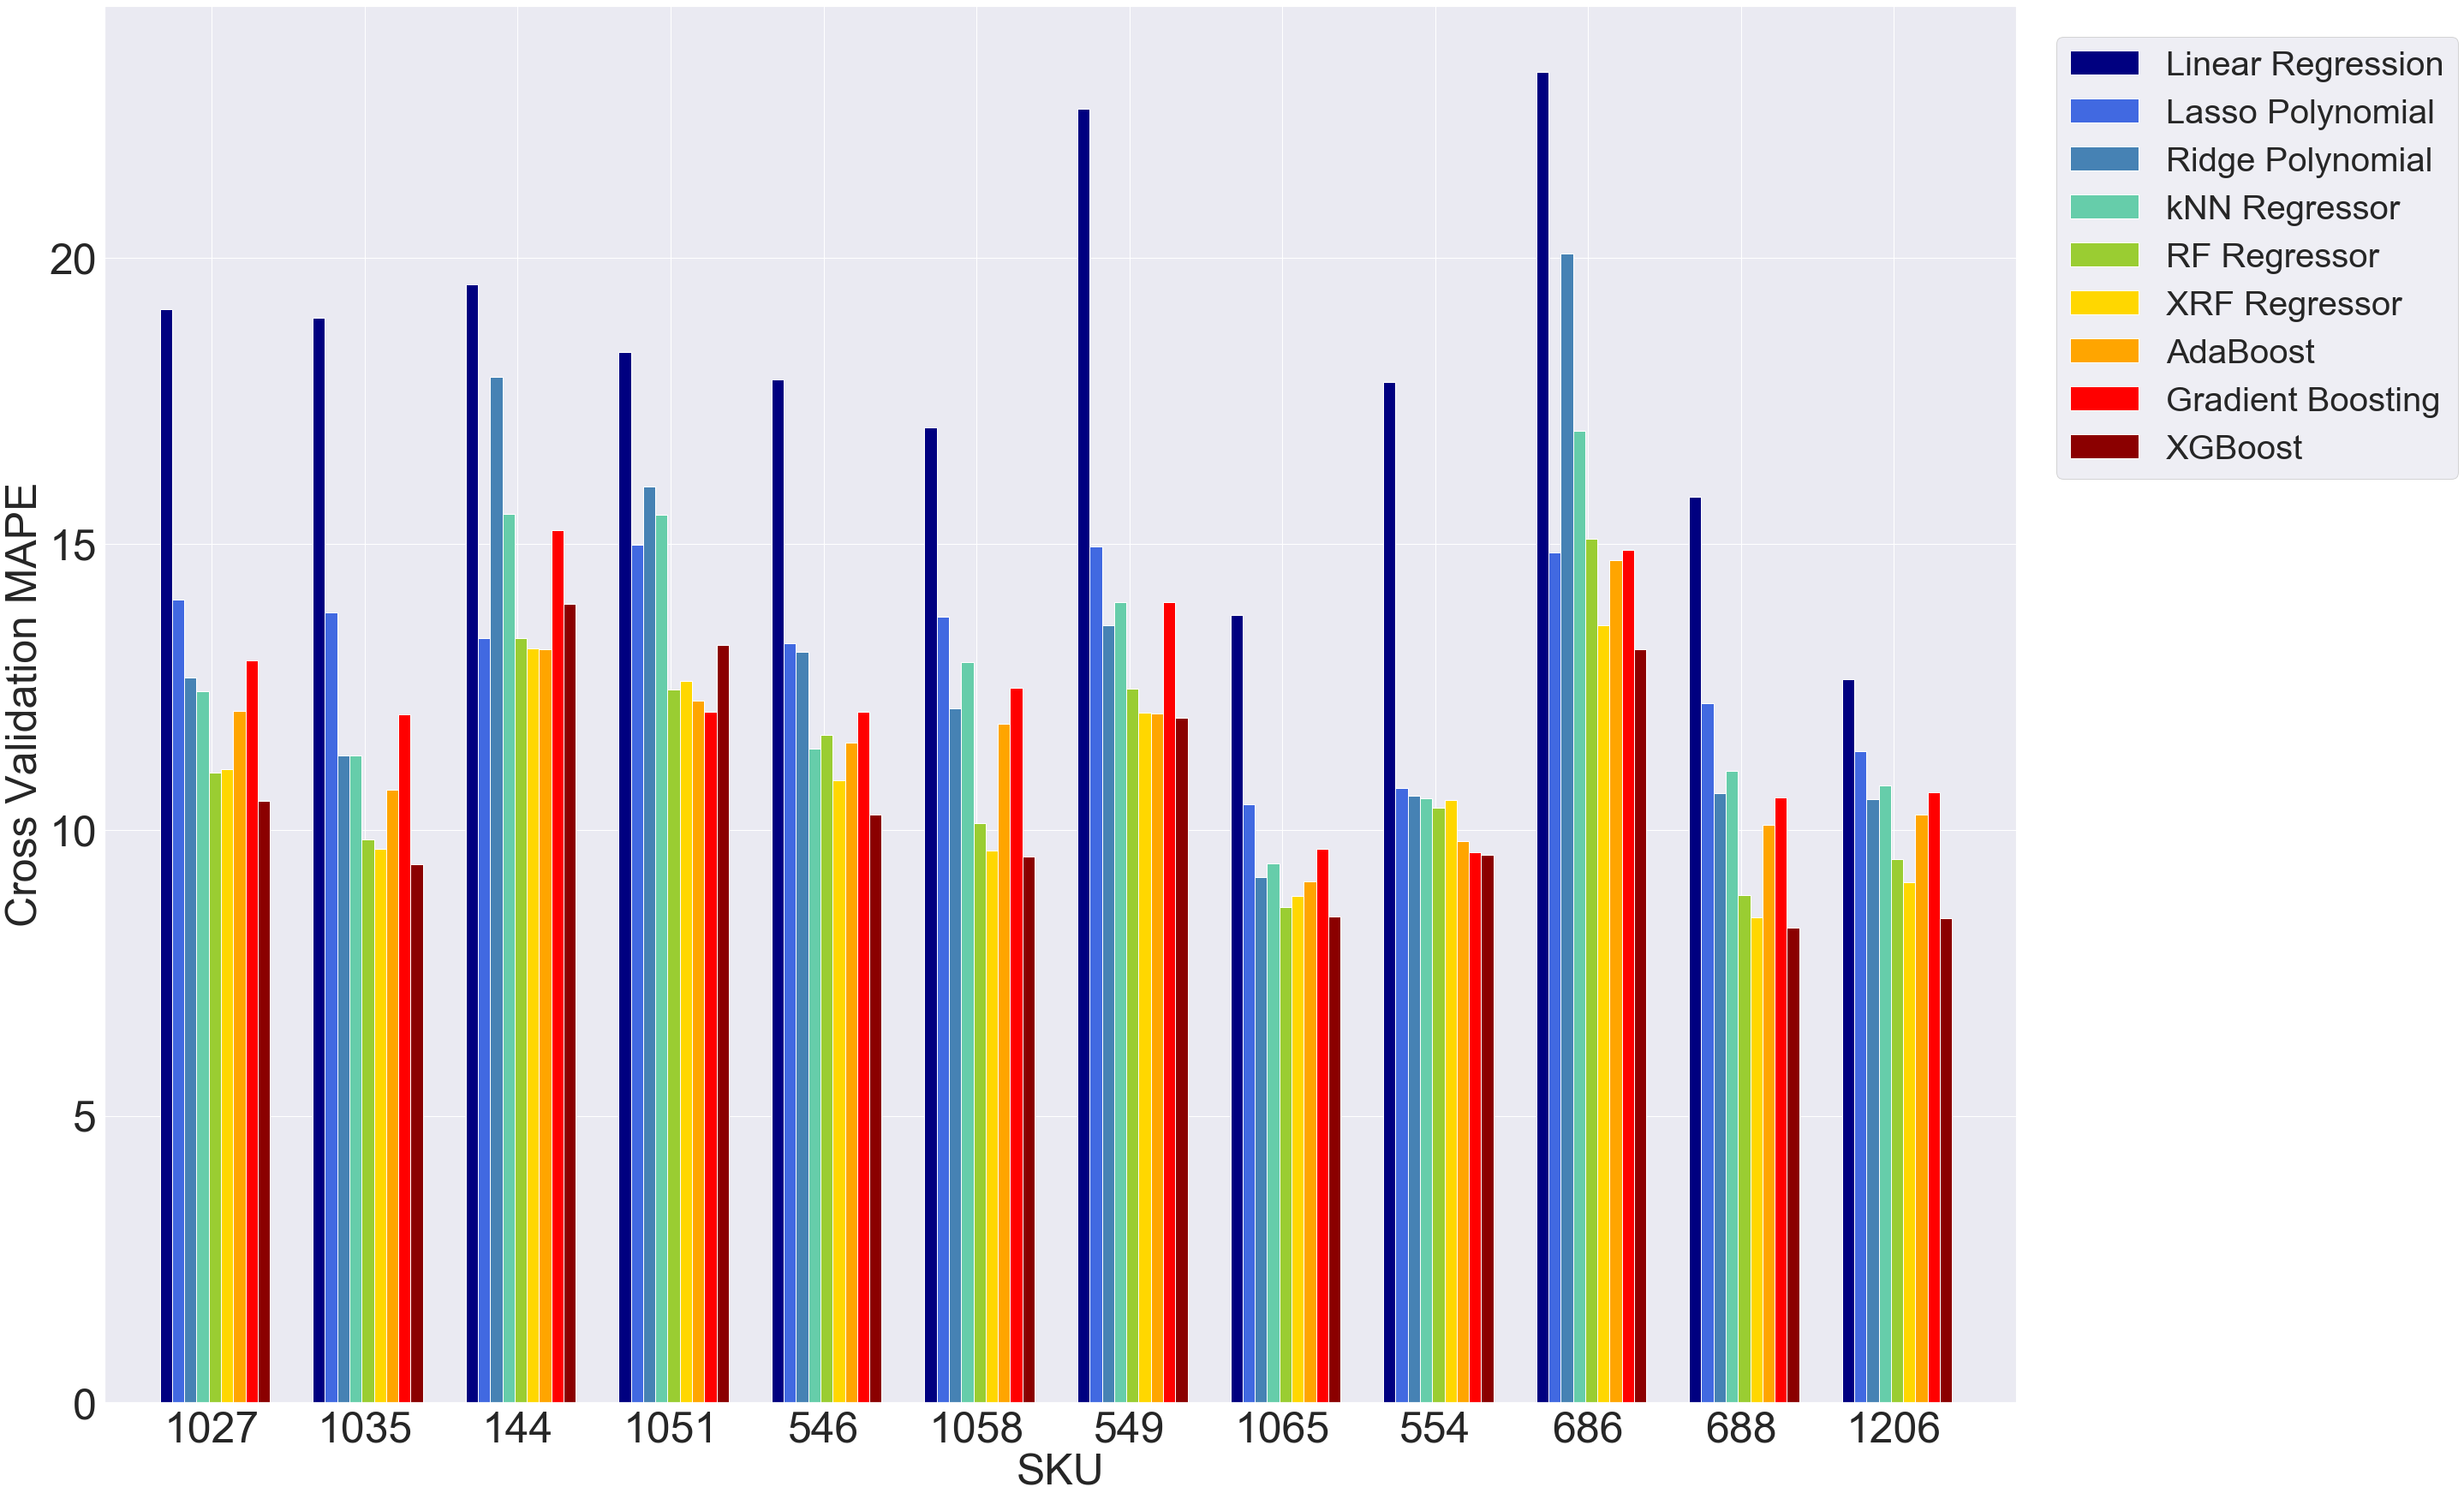

In [27]:
plt.figure(figsize=(40,30))
width=0.08
fontsize=50
mape_df['Linear Regression'].plot( kind="bar", stacked=True, width=width,position=8,color='navy')
mape_df['Lasso Polynomial'].plot( kind="bar", stacked=True, width=width,position=7,color='royalblue')
mape_df['Ridge Polynomial'].plot( kind="bar", stacked=True, width=width,position=6,color='steelblue')
mape_df['kNN Regressor'].plot( kind="bar", stacked=True, width=width,position=5,color='mediumaquamarine')
mape_df['RF Regressor'].plot( kind="bar", stacked=True, width=width,position=4,color='yellowgreen')
mape_df['XRF Regressor'].plot( kind="bar", stacked=True, width=width,position=3,color='gold')
mape_df['AdaBoost'].plot( kind="bar", stacked=True, width=width,position=2,color='orange')
mape_df['Gradient Boosting'].plot( kind="bar", stacked=True, width=width,position=1,color='red')
mape_df['XGBoost'].plot( kind="bar", stacked=True, width=width,position=0,color='darkred')
plt.xticks(np.linspace(0.5,11.5,12)-0.8,fontsize=fontsize,rotation=0)
plt.yticks(fontsize=fontsize)
plt.xlabel('SKU',fontsize=fontsize)
plt.ylabel('Cross Validation MAPE',fontsize=fontsize)
plt.xlim(-1,11.5)
plt.grid(which='both')
plt.legend(loc='upper right', bbox_to_anchor=(1.24, 0.99), prop={'size': 40})

In [274]:
np.linspace(0.5,12.5,12)

array([ 0.5       ,  1.59090909,  2.68181818,  3.77272727,  4.86363636,
        5.95454545,  7.04545455,  8.13636364,  9.22727273, 10.31818182,
       11.40909091, 12.5       ])